In [1]:
%matplotlib inline

import gc
import glob
import itertools
import matplotlib
from matplotlib import pyplot
import numpy
import os
import pandas
import pysam
import seaborn
import sys

pandas.options.display.max_columns = None
pandas.options.display.max_rows = None

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['agg.path.chunksize'] = 10000
print(f'Package versions:\nPython {sys.version}, matplotlib {matplotlib.__version__}, '
      f'numpy {numpy.__version__}, pandas {pandas.__version__}, '
      f'pysam {pysam.__version__}, seaborn {seaborn.__version__}')

Package versions:
Python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0], matplotlib 3.4.2, numpy 1.21.0, pandas 1.1.5, pysam 0.16.0.1, seaborn 0.11.1


In [2]:
def rev_comp(dna_seq):
    bp_map = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
    return ''.join([bp_map[elt] for elt in list(dna_seq[::-1])])

In [3]:
r1_seqs = dict(
    WT =  'GCAAACTCAAACTACGAACGCACTCACAGTCGCATCATAATCCTCTCTCAAGGACTTCAAACTCTACTCCCACTAATAGCTTTTTGATGACTTCTAGCAAGCCTCGCTAACCTCGCCTTACCCCCCACTATTAACCTACTGGGAGAACTCTCTGTGCTAGTAACCACGTTCTCCTGATCAAATATCACTCTCCTACTTACAGGACTCAACATACTAGTCACAGCCCTATACTCCCTCTACATATTTACCACAACACAATGGGGCTCACTCACCCACCACATTAACAACATAAAACCCTCATTCACACGAGAAAACACCCTCATGTTCATACACCT'[:240],
    MUT = 'GCAAACTCAAACTACGAACGCACTCACAGTCGCATCATAATCCTCTCTCAAGGACTTCAAACTCTACTCCCACTAATAGCTTTTTGATGACTTCTAGCAAGCCTCGCTAACCTCGCCTTACCCCCCACTATTAACCTACTGGGAGAACTCTCTGTGCTAGTAACCACGTTCTCCTAATCAAATATCACTCTCCTACTTACAGGACTCAACATACTAGTCACAGCCCTATACTCCCTCTACATATTTACCACAACACAATGGGGCTCACTCACCCACCACATTAACAACATAAAACCCTCATTCACACGAGAAAACACCCTCATGTTCATACACCT'[:240]
)
r1_seqs_r = {v:k for k,v in r1_seqs.items()}

In [4]:
print([idx for idx, (e1,e2) in enumerate(zip(r1_seqs['WT'], r1_seqs['MUT'])) if e1 != e2])

[175]


In [5]:
def allow_substitutions(bc_list, num_subs=2, immutable_bases=[]):
    immutable_bases = set(immutable_bases)
    bc_map = {}
    bc_len = len(bc_list[0])
    if bc_len < num_subs:
        raise Exception('Number of substitutions allowed ({!s}) must be less '
                        'than or equal to the barcode length ({!s})'.format(num_subs, bc_len))
    sub_idx = list(itertools.combinations(numpy.arange(bc_len), num_subs))
    possible_edits = list(set(itertools.permutations(['A', 'C', 'G', 'T', 'N'], num_subs)))
    for bc_elt in bc_list:
        bc_elt_list = list(bc_elt)
        for edit_idx, edit_bases in itertools.product(sub_idx, possible_edits):
            bc_tmp = list(bc_elt_list)
            for idx, base in zip(edit_idx, edit_bases):
                if idx in immutable_bases:
                    continue
                try:
                    bc_tmp[idx] = base
                except:
                    raise Exception(bc_tmp, edit_idx, edit_bases, idx, base)
            bc_map[''.join(bc_tmp)] = bc_elt
    return bc_map

In [6]:
r1_ed1_map = allow_substitutions(list(r1_seqs.values()), 1, immutable_bases=[175])

## Get data

In [7]:
sample_info = pandas.read_csv('./sample_info.csv', index_col=0)
print(sample_info.shape)
sample_info.head()

(9, 10)


,Name,Treatment,Time,O2,Harvesting,DNA isolation,% G>A,Unnamed: 8,Sample name,Sample on plate
Sequencing sample name,,,,,,,,,,
1D0,1E,NT,0 days,21%,12/19/2019,12/19/2019,54.7,NaN,1D0,Plate1-A1
2D0,2E,NT,0 days,21%,12/19/2019,12/19/2019,49.6,NaN,1D10,Plate1-A2
3D0,3E,NT,0 days,21%,12/19/2019,12/19/2019,54.7,NaN,2D0,Plate1-A3
1D10,1E,NT,10 days,21%,12/30/2019,1/27/2020,39.7,NaN,4D0,Plate1-A7
2D10,2E,NT,10 days,21%,12/30/2019,1/27/2020,37.2,NaN,4D10,Plate1-A8


In [8]:
fastq_paths = sorted([elt for elt in glob.glob('./00_fastq/*R1_001.fastq.gz') if 'Undetermined' not in elt])
print(len(fastq_paths))
print('\n'.join(fastq_paths))

9
./00_fastq/1D0_S11_L001_R1_001.fastq.gz
./00_fastq/1D10_S12_L001_R1_001.fastq.gz
./00_fastq/2D0_S18_L001_R1_001.fastq.gz
./00_fastq/2D10_S19_L001_R1_001.fastq.gz
./00_fastq/3D0_S20_L001_R1_001.fastq.gz
./00_fastq/3D10_S21_L001_R1_001.fastq.gz
./00_fastq/7D10_S28_L001_R1_001.fastq.gz
./00_fastq/8D10_S29_L001_R1_001.fastq.gz
./00_fastq/9D10_S30_L001_R1_001.fastq.gz


In [9]:
sample_stats = {'sample_id':[],
                'read_count':[],
                'wt_count':[],
                'mut_count':[],
                'unknown_count':[]}

record_count = 0
read_idx = {}
r1_seq_len_set = set([len(elt) for elt in r1_seqs.values()])
for fastq_path in fastq_paths:
    sample_id = os.path.basename(fastq_path).split('_')[0]
    if sample_id not in sample_info.index.values:
        continue
    read_count = 0
    wt_count = 0
    mut_count = 0
    unknown_count = 0
    with pysam.FastqFile(fastq_path) as fq1_in, pysam.FastqFile(fastq_path.replace('_R1', '_R2')) as fq2_in:
        for r1, r2 in zip(fq1_in, fq2_in):
            read_count += 1
            if record_count and not record_count%5e6:
                print('Processed {!s} reads.'.format(record_count))
            record_count += 1

            #tally read1 matches
            for seq_len, offset in itertools.product(r1_seq_len_set, range(1)):
                #test read1
                try:
                    r1_seq_corr = r1_ed1_map[r1.sequence[offset:offset+seq_len]]
                except KeyError:
                    pass
                else:
                    if r1_seqs_r[r1_seq_corr] == 'WT':
                        wt_count += 1
                    elif r1_seqs_r[r1_seq_corr] == 'MUT':
                        mut_count += 1
                    break
                #test read2
                try:
                    r1_seq_corr = r1_ed1_map[r2.sequence[offset:offset+seq_len]]
                except KeyError:
                    pass
                else:
                    if r1_seqs_r[r1_seq_corr] == 'WT':
                        wt_count += 1
                    elif r1_seqs_r[r1_seq_corr] == 'MUT':
                        mut_count += 1
                    break
            else:
                unknown_count += 1
#            break
        sample_stats['sample_id'].append(sample_id)
        sample_stats['read_count'].append(read_count)
        sample_stats['wt_count'].append(wt_count)
        sample_stats['mut_count'].append(mut_count)
        sample_stats['unknown_count'].append(unknown_count)
#        break
else:
    print(f'Finished processing {record_count} total reads.')

sample_stats = pandas.DataFrame(sample_stats)
gc.collect()
print(sample_stats.shape)
sample_stats.head()

Finished processing 676102 total reads.
(9, 5)


,sample_id,read_count,wt_count,mut_count,unknown_count
0,1D0,77404,29271,35372,12761
1,1D10,77539,40296,26523,10720
2,2D0,81389,34591,34147,12651
3,2D10,72598,40872,24192,7534
4,3D0,70535,26839,32430,11266


In [10]:
xorder = sorted(sample_stats['sample_id'].values, key=lambda x:tuple(int(elt) for elt in x.split('D')[::-1]))
sample_stats = sample_stats.set_index('sample_id').loc[xorder].reset_index()
sample_stats.head()

,sample_id,read_count,wt_count,mut_count,unknown_count
0,1D0,77404,29271,35372,12761
1,2D0,81389,34591,34147,12651
2,3D0,70535,26839,32430,11266
3,1D10,77539,40296,26523,10720
4,2D10,72598,40872,24192,7534


In [11]:
sample_info = sample_info.join(sample_stats.set_index('sample_id')).reset_index()
print(sample_info.shape)
sample_info.head()

(9, 15)


,Sequencing sample name,Name,Treatment,Time,O2,Harvesting,DNA isolation,% G>A,Unnamed: 8,Sample name,Sample on plate,read_count,wt_count,mut_count,unknown_count
0,1D0,1E,NT,0 days,21%,12/19/2019,12/19/2019,54.7,NaN,1D0,Plate1-A1,77404,29271,35372,12761
1,2D0,2E,NT,0 days,21%,12/19/2019,12/19/2019,49.6,NaN,1D10,Plate1-A2,81389,34591,34147,12651
2,3D0,3E,NT,0 days,21%,12/19/2019,12/19/2019,54.7,NaN,2D0,Plate1-A3,70535,26839,32430,11266
3,1D10,1E,NT,10 days,21%,12/30/2019,1/27/2020,39.7,NaN,4D0,Plate1-A7,77539,40296,26523,10720
4,2D10,2E,NT,10 days,21%,12/30/2019,1/27/2020,37.2,NaN,4D10,Plate1-A8,72598,40872,24192,7534


In [12]:
sample_info['sample_name'] = (sample_info['Time'] + '_' + sample_info['O2'] 
                              + '_' + sample_info['Treatment'] + '_' + sample_info['Name'])

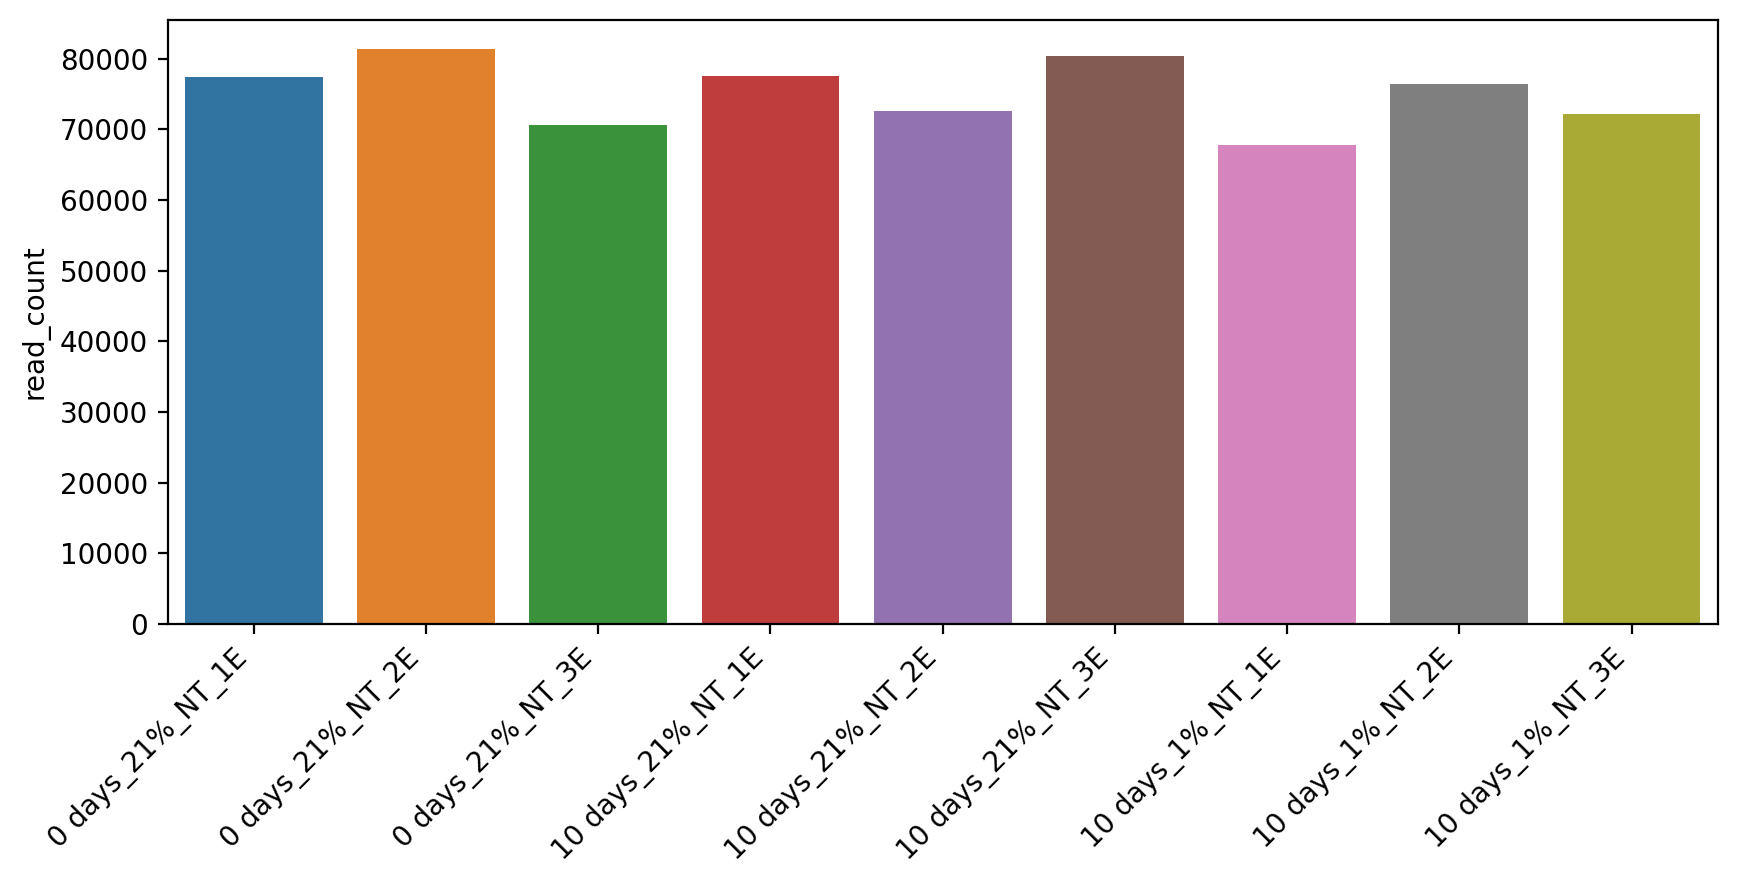

In [13]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10,4))
seaborn.barplot(data=sample_info, x='sample_name', y='read_count', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
axes.set_xlabel('')
fig.show()

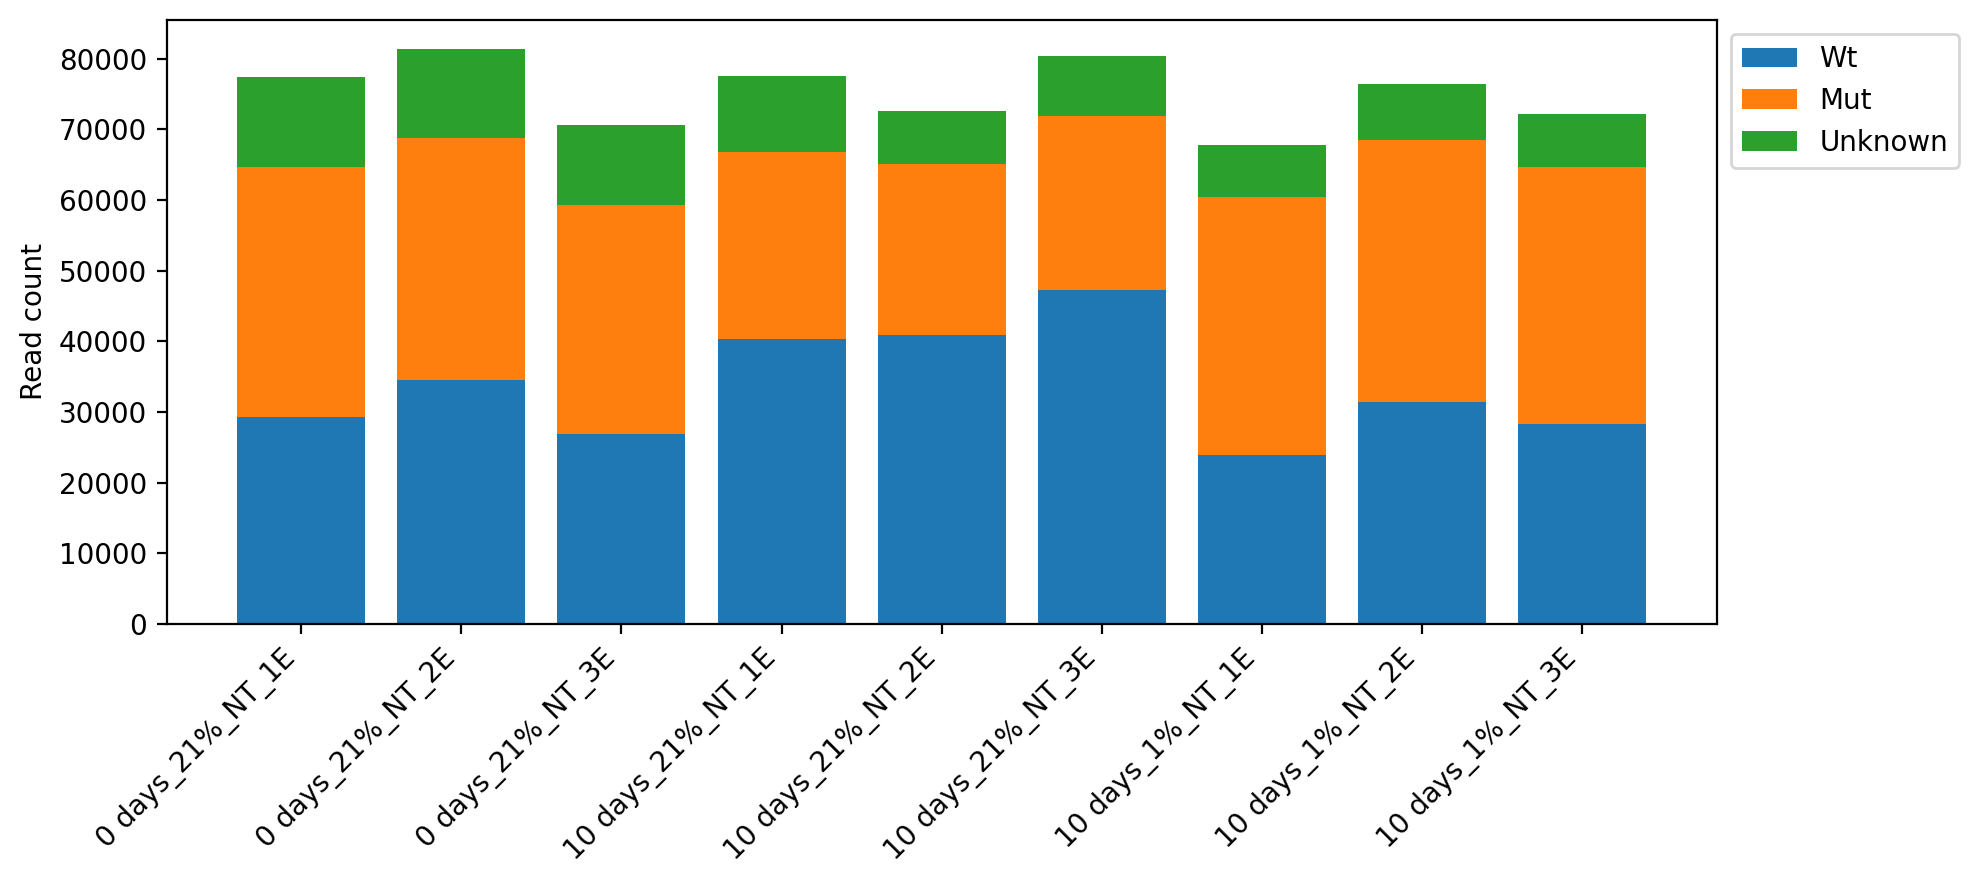

In [14]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10,4))
xticks = numpy.arange(sample_info.shape[0])
bottom = numpy.zeros(sample_info.shape[0])
for data_col in ['wt_count', 'mut_count', 'unknown_count']:
    axes.bar(x=xticks, height=sample_info[data_col].values, bottom=bottom, label=data_col.split('_')[0].capitalize())
    bottom += sample_info[data_col].values
axes.set_xticks(xticks)
axes.set_xticklabels(sample_info['sample_name'].values, ha='right', rotation=45)
axes.set_xlabel('')
axes.set_ylabel('Read count')
axes.legend(loc='upper left', bbox_to_anchor=[1,1])
fig.show()

In [15]:
sample_info['mut_het'] = sample_info['mut_count']/(sample_info['wt_count'] + sample_info['mut_count'])
sample_info.head()

,Sequencing sample name,Name,Treatment,Time,O2,Harvesting,DNA isolation,% G>A,Unnamed: 8,Sample name,Sample on plate,read_count,wt_count,mut_count,unknown_count,sample_name,mut_het
0,1D0,1E,NT,0 days,21%,12/19/2019,12/19/2019,54.7,NaN,1D0,Plate1-A1,77404,29271,35372,12761,0 days_21%_NT_1E,0.547190
1,2D0,2E,NT,0 days,21%,12/19/2019,12/19/2019,49.6,NaN,1D10,Plate1-A2,81389,34591,34147,12651,0 days_21%_NT_2E,0.496770
2,3D0,3E,NT,0 days,21%,12/19/2019,12/19/2019,54.7,NaN,2D0,Plate1-A3,70535,26839,32430,11266,0 days_21%_NT_3E,0.547166
3,1D10,1E,NT,10 days,21%,12/30/2019,1/27/2020,39.7,NaN,4D0,Plate1-A7,77539,40296,26523,10720,10 days_21%_NT_1E,0.396938
4,2D10,2E,NT,10 days,21%,12/30/2019,1/27/2020,37.2,NaN,4D10,Plate1-A8,72598,40872,24192,7534,10 days_21%_NT_2E,0.371819


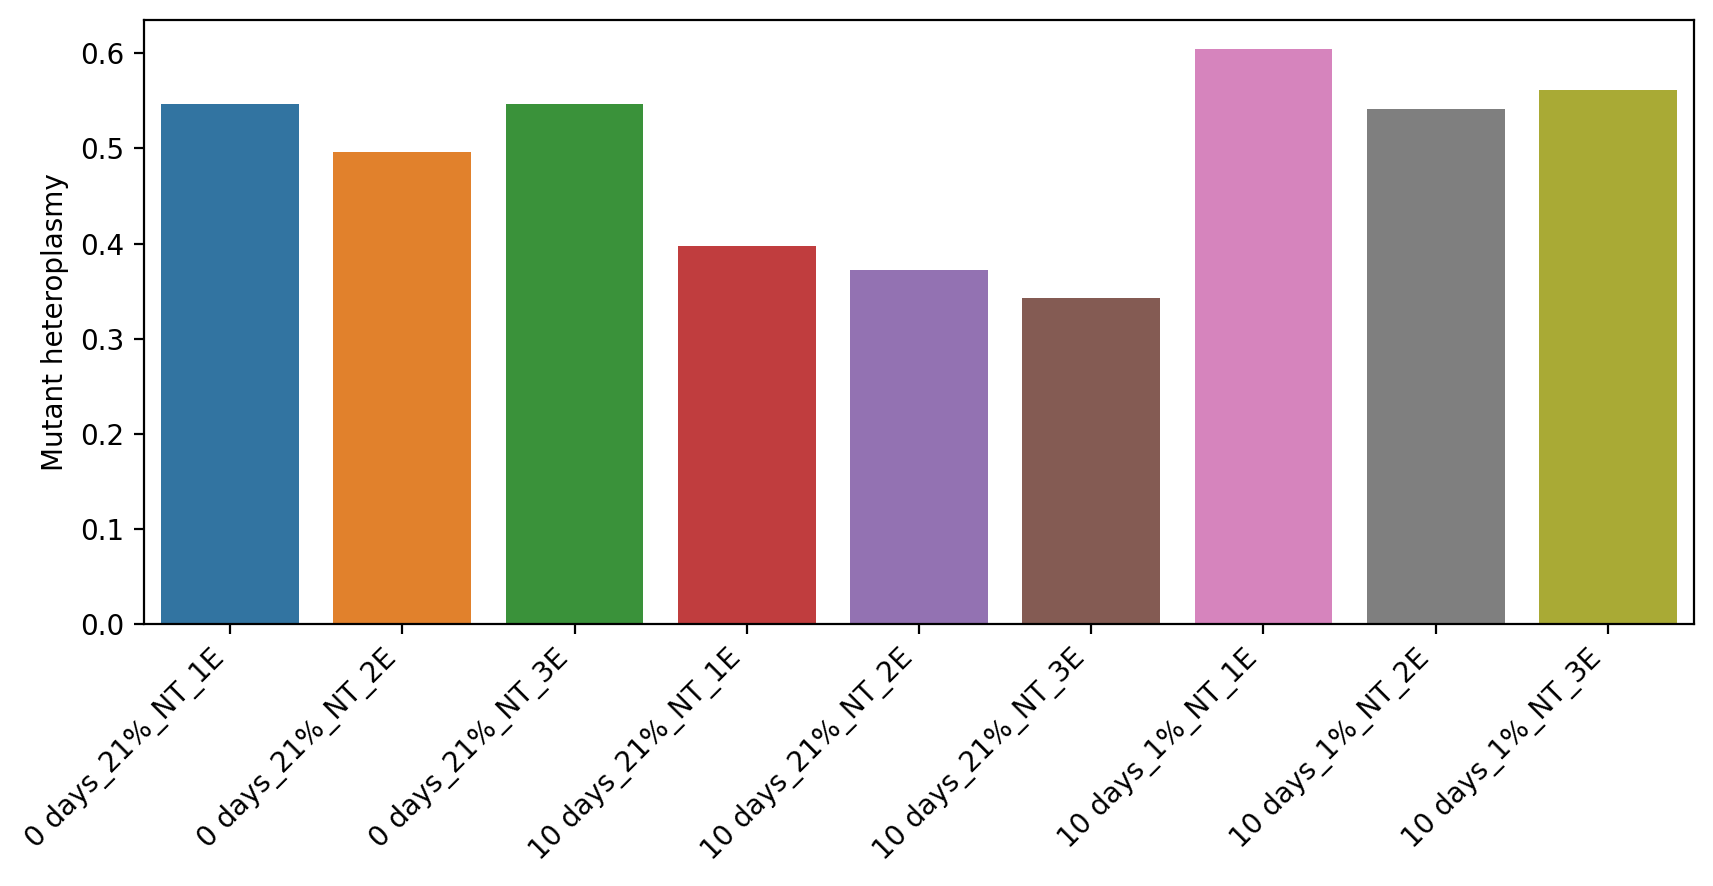

In [16]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10,4))
seaborn.barplot(data=sample_info, x='sample_name', y='mut_het', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
axes.set_xlabel('')
axes.set_ylabel('Mutant heteroplasmy')
fig.show()

In [17]:
sample_info['condition'] = ['_'.join(elt.split('_')[:-1]) + '_' + elt[-1] for elt in sample_info['sample_name'].values]

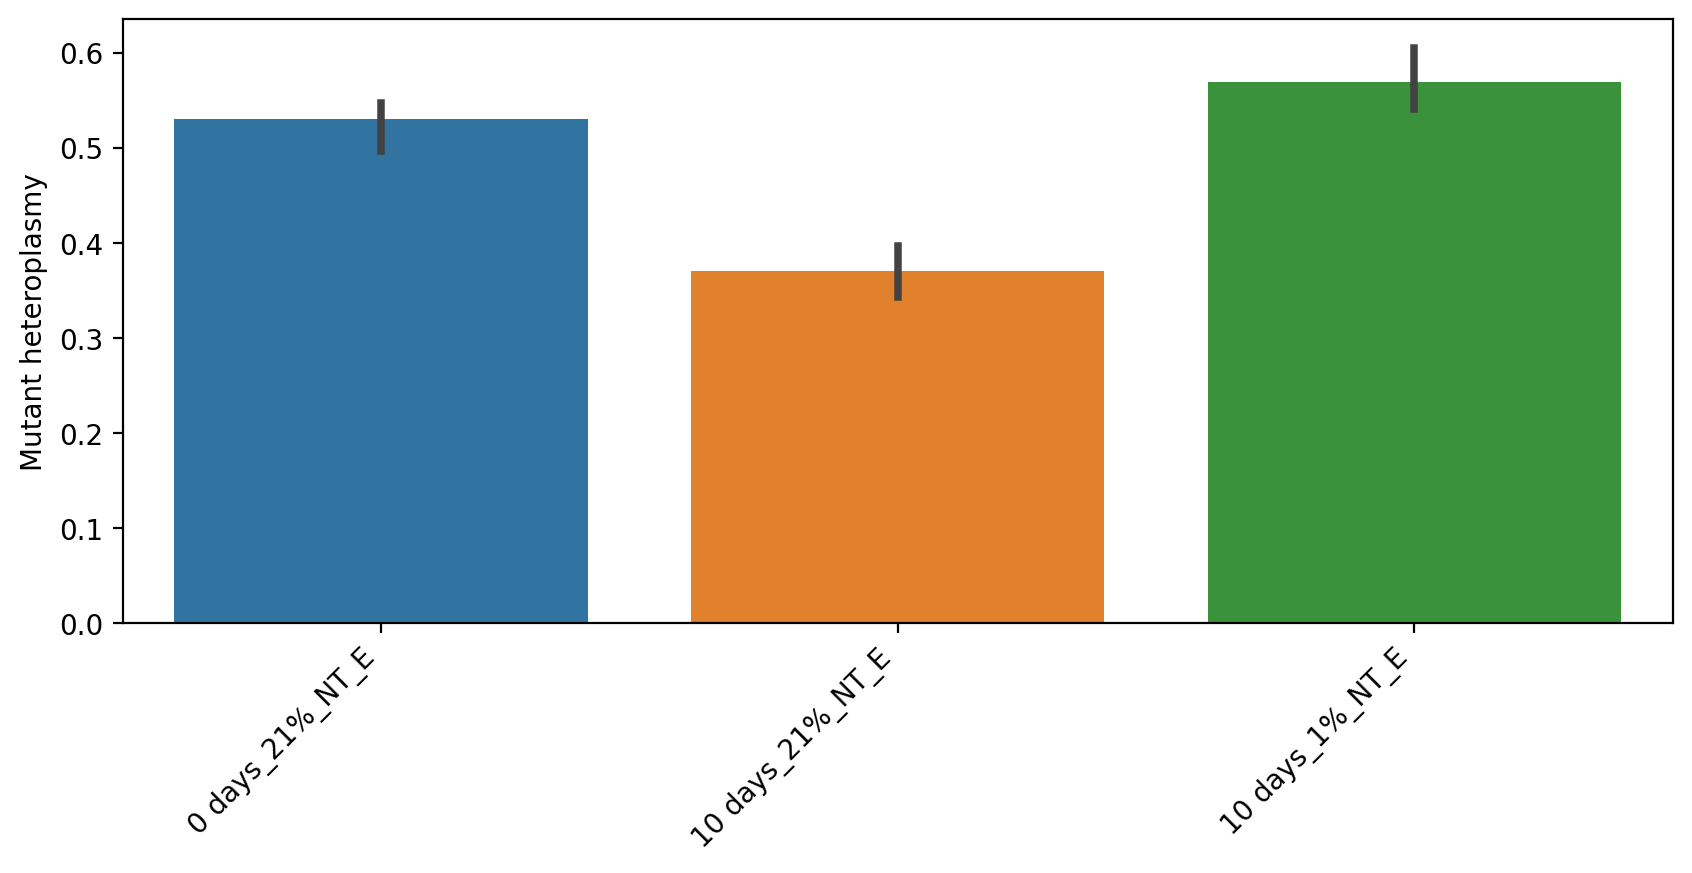

In [18]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10,4))
seaborn.barplot(data=sample_info, x='condition', y='mut_het', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
axes.set_xlabel('')
axes.set_ylabel('Mutant heteroplasmy')
fig.show()

In [19]:
sample_info.to_csv('./bulk_normoxia_hypoxia.count_data.csv', index=False)